In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
import IPython.display as ipd

%matplotlib notebook

def exp_chirp(duration=2, sr=2**14, f0=110, gamma=0.5):
    t = torch.arange(0, duration, 1/sr)
    phi = f0 / (gamma*np.log(2)) * (2 ** (gamma*t) - 1)
    return torch.sin(2*np.pi*phi)


def sinusoid(duration=2, sr=2**14, f0=110):
    t = torch.arange(0, duration, 1/sr)
    return torch.sin(2 * np.pi * f0 * t)


def generate(f_c, f_m, gamma=0.5, duration=2, sr=2**14):
    x_c = exp_chirp(duration=duration, sr=sr, gamma=gamma, f0=f_c) # carrier chirp
    x_m = sinusoid(duration, sr=sr, f0=f_m)
    x = x_c * x_m * torch.hann_window(duration * sr)
    return x


def plot(x, sr=2**14):
    fig, axes = plt.subplots(2, 1, figsize=(8, 8))
    librosa.display.waveshow(x.numpy(), sr=sr, ax=axes[0])
    axes[0].set_title("Waveplot of the signal")
    hop_length=256
    C = librosa.cqt(
        x.numpy(),
        fmin=55, bins_per_octave=12, n_bins=72, sr=sr, hop_length=hop_length)
    librosa.display.specshow(
        librosa.amplitude_to_db(np.abs(C)),
        x_axis="time", sr=sr, hop_length=hop_length,
        y_axis="cqt_hz", bins_per_octave=12,
        ax=axes[1])
    axes[1].set_title("Time-Frequency Spectrogram of the signal")
    fig.tight_layout()
    
def disp_audio(x, rate=2**14):
    return ipd.Audio(x, rate=rate, autoplay=True)

## Amplitude-modulated Chirp Synthesis

<IPython.core.display.Javascript object>


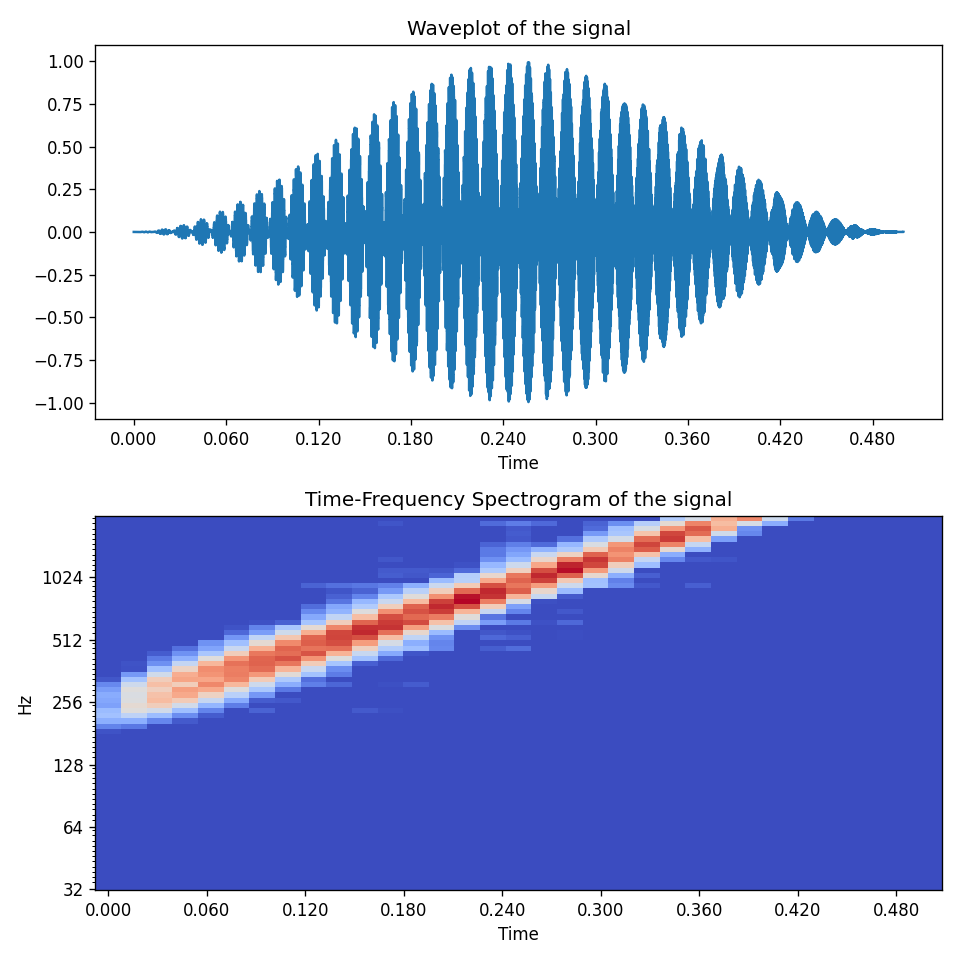

In [35]:
x = generate(f_c=200, f_m=20, gamma=4, duration=1, sr=2**13)
plot(x)
disp_audio(x)

In [36]:
import tqdm

f0s = np.logspace(np.log10(100), np.log10(200), 16)
fms = np.logspace(np.log10(4), np.log10(32), 16)
gammas = np.logspace(np.log10(0.5), np.log10(4), 16)

duration, sr = 1, 2**13

audio = torch.zeros(len(f0s), len(fms), len(gammas), duration * sr)
cmap = torch.zeros(3, len(f0s) * len(fms) * len(gammas))
c = 0
for i, f0 in tqdm.tqdm(enumerate(f0s)):
    for j, fm in enumerate(fms):
        for k, gamma in enumerate(gammas):
            audio[i, j, k] = generate(f0, fm, gamma, sr=sr, duration=duration)
            cmap[0, c], cmap[1, c], cmap[2, c] = f0, fm, gamma
            c += 1
            
X = audio.view(-1, audio.shape[-1])

16it [00:01, 10.89it/s]


## Joint Time-Frequency Scattering

In [20]:
from kymatio.torch import TimeFrequencyScattering1D
import time

N = duration * sr

jtfs = TimeFrequencyScattering1D(
    shape=(N, ),
    T=N,
    Q=8,
    J=12,
    max_pad_factor=1, 
    max_pad_factor_fr=1).cuda()

In [21]:
n_samples = X.shape[0]
n_paths = jtfs(X[0]).shape[1]
sx = torch.zeros(n_samples, n_paths)

for i in tqdm.tqdm(range(n_samples)):
    sx[i, :] = jtfs(X[i, :])[:, :, 0]

100%|██████████████████████████████████████████████████████████████████████████████████| 4096/4096 [09:58<00:00,  6.84it/s]


0.2144489288330078


<IPython.core.display.Javascript object>


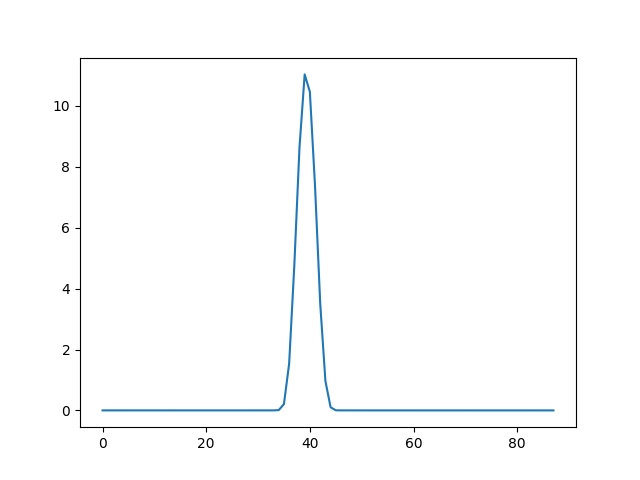

In [26]:
%matplotlib notebook
start = time.time()

sx = jtfs(X[0, :].cuda())
print(time.time() - start)
plt.plot(sx[0].cpu().numpy().ravel())

In [58]:
jtfs.meta()[1]["xi"].shape

(198, 11, 3)

### Time Scattering

In [44]:
from kymatio.torch import Scattering1D
import time

N = duration * sr

scat = Scattering1D(shape=(N, ),
                    T=N,
                    Q=8,
                    J=12).cuda()
X = X.cuda()
n_samples = X.shape[0]

n_paths = scat(X[0]).shape[0]
sx = torch.zeros(n_samples, n_paths)

for i in tqdm.tqdm(range(n_samples)):
    sx[i, :] = scat(X[i, :])[:, 0]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4096/4096 [09:30<00:00,  7.19it/s]


### MFCC

In [59]:
from torchaudio.transforms import MFCC

X = X.cuda()

mfccs = MFCC(sample_rate=sr, log_mels=True, n_mfcc=40).cuda()(X).mean(dim=-1).cpu().numpy()

### Manifold embedding of the nearest neighbour graph

In [10]:
def plot_isomap(Y, cmap):
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], c=cmap[0], cmap='bwr');
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    # f modulator
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], c=cmap[1], cmap='bwr');
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # chirp rate
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], c=cmap[2], cmap='bwr');
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)

<IPython.core.display.Javascript object>


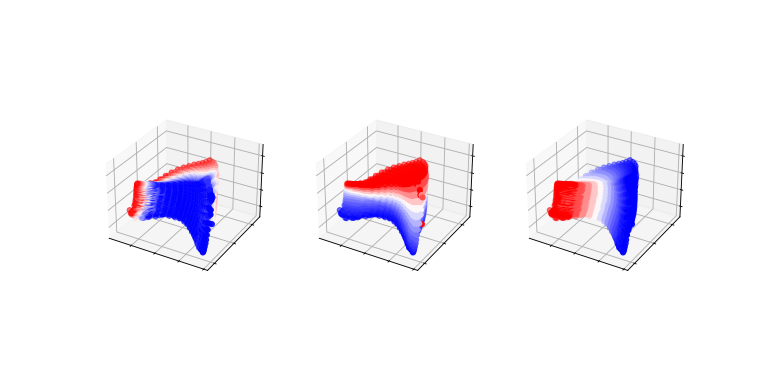

In [26]:
from sklearn.manifold import Isomap

embedding = Isomap(n_components=3, n_neighbors=40)
Y = embedding.fit_transform(sx)
plot_isomap(Y, cmap)

## Open-L3

In [ ]:
import openl3
X_ol3, _ = openl3.get_audio_embedding(
    list(X.numpy()), 
    sr, 
    batch_size=32,
    frontend='kapre',
    content_type='music')

2022-02-12 10:20:17.595005: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: import/linux/cuda/11.5/lib64:/usr/local/cuda-10.2/lib64:import/linux/python/3.6.6/lib:/usr/local/cuda/lib64/:/usr/local/cuda-10.0/lib64
2022-02-12 10:20:17.595070: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-02-12 10:20:17.595697: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical op

644/768 [========================>.....] - ETA: 6:30

### Manifold embedding of the nearest neighbour graph

<IPython.core.display.Javascript object>


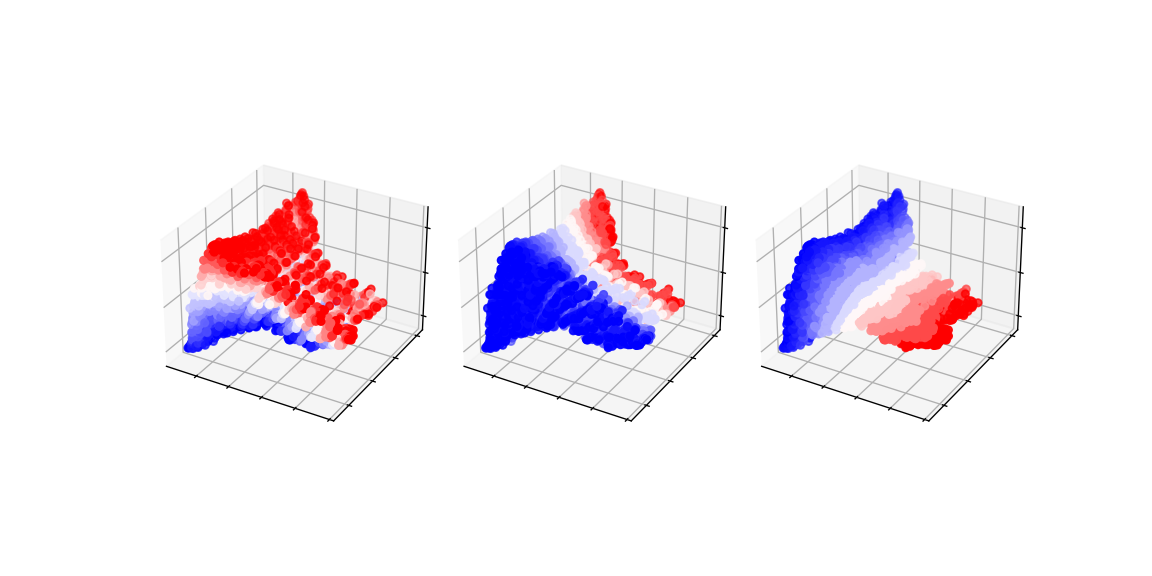

In [11]:
from sklearn.manifold import Isomap

X_ol3 = np.load('/homes/cv300/Documents/scattering/data/openl3.npy')
cmap = np.load('/homes/cv300/Documents/scattering/data/cmap.npy')

embedding = Isomap(n_components=3, n_neighbors=40)
Y = embedding.fit_transform(X_ol3)
plot_isomap(Y, cmap.T)

In [30]:
for i in range(sx.shape[0]):
    np.save(f'/homes/cv300/Documents/scattering/data/jtfs/{i}', sx[i])
    np.save(f'/homes/cv300/Documents/scattering/data/theta/{i}', cmap.T[i])

### Load JTFS

In [28]:
import os 

data_dir = '/homes/cv300/Documents/scattering/data'
jtfs_dir = os.path.join(data_dir, 'jtfs')
theta_dir = os.path.join(data_dir, 'theta')

features = [(np.load(os.path.join(jtfs_dir, f)), np.load(os.path.join(theta_dir, f))) 
            for f in os.listdir(jtfs_dir)]
jtfs = np.stack([f[0] for f in features])
theta = np.stack([f[1] for f in features])


(4096, 8141)

<IPython.core.display.Javascript object>


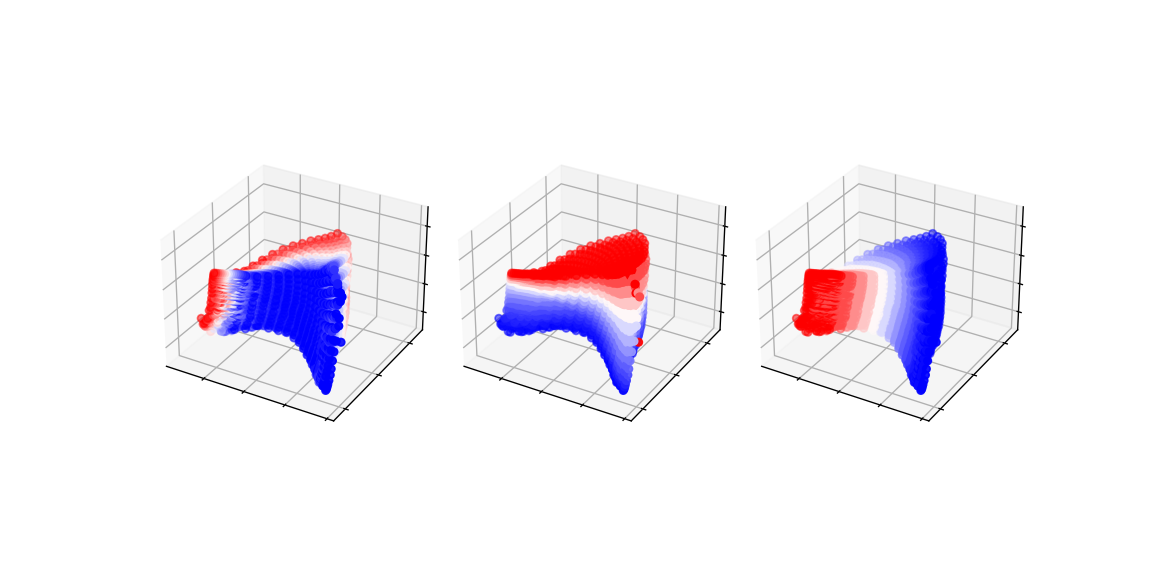

In [33]:
embedding = Isomap(n_components=3, n_neighbors=40)
Y = embedding.fit_transform(jtfs)
plot_isomap(Y, theta.T)

### Time Scattering

<IPython.core.display.Javascript object>


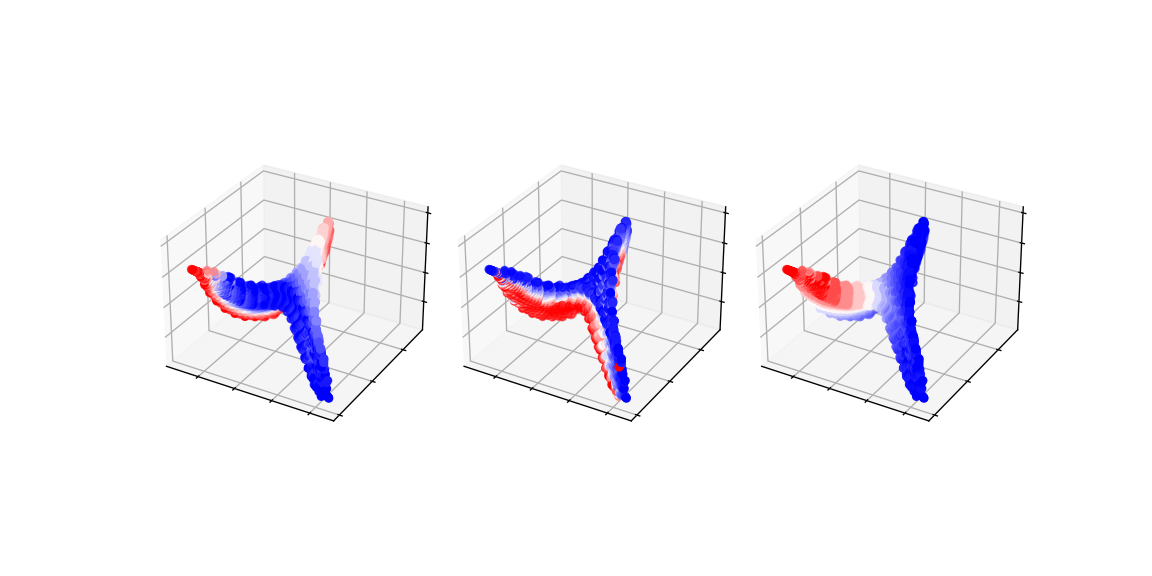

In [47]:
from sklearn.manifold import Isomap

embedding = Isomap(n_components=3, n_neighbors=40)
Y = embedding.fit_transform(sx)
plot_isomap(Y, cmap)

### MFCC embedding

<IPython.core.display.Javascript object>


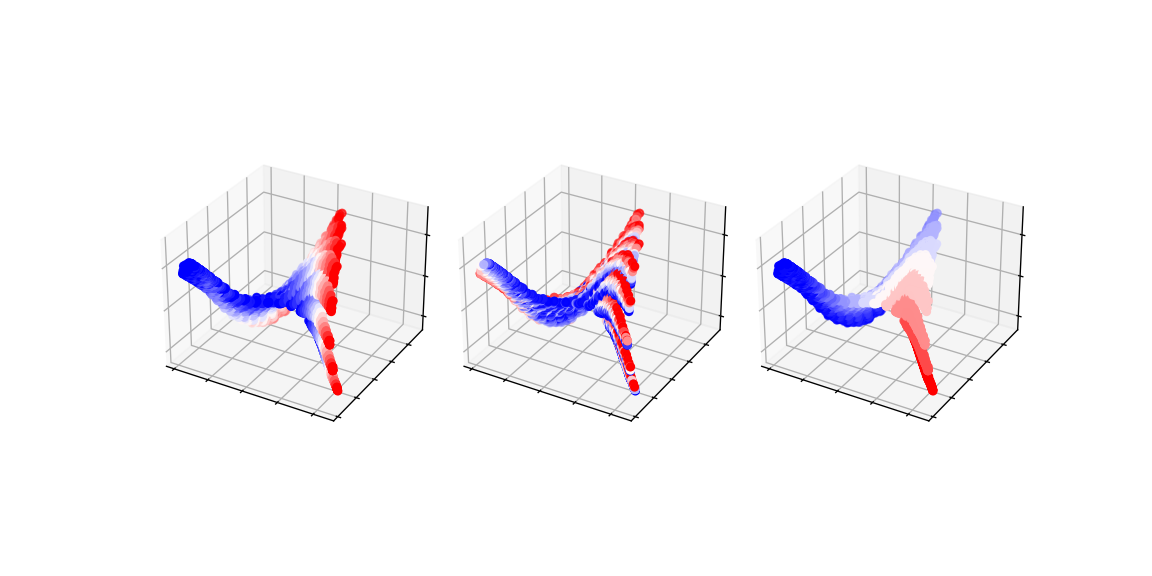

In [60]:
from sklearn.manifold import Isomap

embedding = Isomap(n_components=3, n_neighbors=40)
Y = embedding.fit_transform(mfccs)
plot_isomap(Y, cmap)

Generating Audio ...


16it [01:08,  4.29s/it]


Extracting MFCCs ...


16it [01:42,  6.41s/it]


<IPython.core.display.Javascript object>


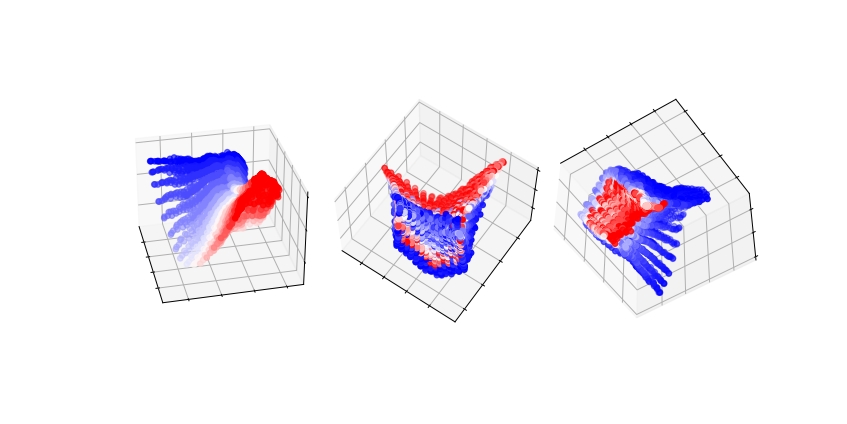

In [4]:
%matplotlib notebook

import os, sys
import fire, tqdm
import numpy as np, matplotlib.pyplot as plt, scipy
import librosa, librosa.feature, librosa.display
import torch

import openl3
from kymatio.torch import Scattering1D, TimeFrequencyScattering1D

from sklearn.manifold import Isomap

def sinusoid(f0, duration, sr):
    t = np.arange(0, duration, 1/sr)
    return np.sin(2 * np.pi * f0 * t)


def generate(f_c, f_m, gamma, bw=2, duration=2, sr=2**14):
    sigma0 = 0.1
    t = np.arange(-duration/2, duration/2, 1/sr)
    chirp_phase = 2*np.pi*f_c / (gamma*np.log(2)) * (2 ** (gamma*t) - 1)
    carrier = np.sin(chirp_phase)
    modulator = np.sin(2 * np.pi * f_m * t)
    window_std = sigma0 * bw / gamma
    window = scipy.signal.gaussian(duration*sr, std=window_std*sr)
    x = carrier * modulator * window
    return x


def generate_audio(f0s, fms, gammas, duration, sr):
    audio = np.zeros((len(f0s), len(fms), len(gammas), duration * sr))
    cmap = np.zeros((3, len(f0s) * len(fms) * len(gammas)))
    c = 0

    print('Generating Audio ...')
    for i, f0 in tqdm.tqdm(enumerate(f0s)):
        for j, fm in enumerate(fms):
            for k, gamma in enumerate(gammas):
                audio[i, j, k, :] = generate(f0, fm, gamma, sr=sr, duration=duration)
                audio[i, j, k, :] = audio[i, j, k, :] / np.linalg.norm(audio[i, j, k, :])
                cmap[0, c], cmap[1, c], cmap[2, c] = f0, fm, gamma
                c += 1
    return audio, cmap


def extract_mfcc(audio, f0s, fms, gammas, sr, n_mfcc = 20):
    mfcc = np.zeros((len(f0s), len(fms), len(gammas), n_mfcc))

    print('Extracting MFCCs ...')
    for i, f0 in tqdm.tqdm(enumerate(f0s)):
        for j, fm in enumerate(fms):
            for k, gamma in enumerate(gammas):
                mfcc[i, j, k,:] = np.mean(librosa.feature.mfcc(y=audio[i,j,k], sr=sr), axis=-1)
    
    return mfcc.reshape(-1, mfcc.shape[-1])


def extract_time_scattering(audio, duration, sr, **ts_kwargs):
    N = duration * sr
    scat = Scattering1D(shape=(N, ),
                        T=N,
                        Q=1,
                        J=12).cuda()
    
    X = torch.tensor(audio).cuda()
    n_samples = X.shape[0]
    n_paths = scat(X[0]).shape[0]

    sx = torch.zeros(n_samples, n_paths)

    for i in tqdm.tqdm(range(n_samples)):
        sx[i, :] = scat(X[i, :])[:, 0]
    return sx.cpu().numpy()


def extract_jtfs(audio, duration, sr, **jtfs_kwargs):
    N = duration * sr
    jtfs = TimeFrequencyScattering1D(
        shape=(N, ),
        T=N,
        Q=8,
        J=12,
        max_pad_factor=1, 
        max_pad_factor_fr=1).cuda()
    X = torch.tensor(audio).cuda()
    n_samples, n_paths = X.shape[0], jtfs(X[0]).shape[1]
    sx = torch.zeros(n_samples, n_paths)

    for i in tqdm.tqdm(range(n_samples)):
        sx[i, :] = jtfs(X[i, :])[:, :, 0]

    return sx.cpu().numpy()


def extract_openl3(audio, sr, **ol3_kwargs):
    X_ol3, _ = openl3.get_audio_embedding(
        list(audio), 
        sr, 
        batch_size=32,
        frontend='kapre',
        content_type='music')
    return np.stack(X_ol3).mean(axis=1)


def extract_strf(audio, duration, sr, **strf_kwargs):
    sys.path.insert(1, os.getcwd() + '/strf-like-model')
    import auditory

    X = audio 
    n_samples = X.shape[0]
    S = auditory.strf(X[0, :], audio_fs=sr, duration=duration)
    S = np.concatenate((
        S[0].reshape((S[0].shape[0],     S[0].shape[1], -1)),
        S[1][:, :, np.newaxis]),
        axis=-1).mean(axis=0)
    n_freqs, n_paths = S.shape
    sx = np.zeros((n_samples, n_freqs, n_paths))

    for i in tqdm.tqdm(range(n_samples)):
        S = auditory.strf(X[i], audio_fs=sr, duration=duration)
        S = np.concatenate((
            S[0].reshape((S[0].shape[0], S[0].shape[1], -1)),
            S[1][:, :, np.newaxis]),
            axis=-1).mean(axis=0)
        sx[i, :] = S

    return sx.reshape((sx.shape[0], -1))


def plot_isomap(Y, cmap, out_dir):
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], c=cmap[0], cmap='bwr');
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    # f modulator
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], c=cmap[1], cmap='bwr');
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # chirp rate
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], c=cmap[2], cmap='bwr');
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.savefig(os.path.join(out_dir, 'isomap.png'))


def run_isomaps(X, cmap, out_dir):

    Y = {}
    ratios = {}
    models = {}

    for feat in X.keys():
        feat_dir = os.path.join(out_dir, feat)

        os.makedirs(feat_dir, exist_ok=True)
        models[feat] = Isomap(n_components=3, n_neighbors=40)
        Y[feat] = models[feat].fit_transform(X[feat])

        plot_isomap(Y[feat], cmap, feat_dir)

        knn = models[feat].nbrs_.kneighbors()
        ratios[feat] = np.vstack([
            np.exp(np.mean(np.log(cmap[:, knn[1][i, :]]), axis=1)) / cmap[:, i]
            for i in range(X[feat].shape[0])
        ])



def run_isomap(
    n_steps = 16,
    f0_min = 512, 
    f0_max = 1024,
    fm_min = 4,
    fm_max = 16,
    gamma_min = 0.5,
    gamma_max = 4,
    bw = 2, 
    duration = 4, 
    sr = 2**13,
    out_dir = '/img'):


    out_dir = os.getcwd() + out_dir

    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    f0s = np.logspace(np.log10(f0_min), np.log10(f0_max), n_steps)
    fms = np.logspace(np.log10(fm_min), np.log10(fm_max), n_steps)
    gammas = np.logspace(np.log10(gamma_min), np.log10(gamma_max), n_steps)
    
    audio, cmap = generate_audio(f0s, fms, gammas, duration, sr)

    # ol3 = extract_openl3(audio.reshape(-1, audio.shape[-1]), sr)
    mfcc = extract_mfcc(audio, f0s, fms, gammas, sr)
#     ts = extract_time_scattering(audio.reshape(-1, audio.shape[-1]), duration, sr)
    # jtfs = extract_jtfs(audio.reshape(-1, audio.shape[-1]), duration, sr)
    
    # strf = extract_strf(audio.reshape(-1, audio.shape[-1]), duration, sr)

    # X = {"mfcc": mfcc, "ts": ts, "jtfs": jtfs, "ol3": ol3}
    X = {"mfcc": mfcc}
    # X = {"strf": strf}

    run_isomaps(X, cmap, out_dir)


run_isomap()